In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r'C:\Users\mahat\OneDrive\Desktop\Optimizing-Household-Electricity-through-Machine-Learning-main\Datasets\electricity_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Date'].dt.year == 2021]
df.reset_index(drop=True, inplace=True)

In [3]:
df.head(3)

,Date,Total_Consumption
0,2021-01-01,7.7
1,2021-01-02,8.5
2,2021-01-03,7.7


In [4]:
df.shape

(203, 2)

In [5]:
import math
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import matplotlib.pyplot as plt

actual_vals = df.Total_Consumption.values
actual_log = np.log10(actual_vals)

train, test = actual_vals[0:-80], actual_vals[-80:]
train_log, test_log = np.log10(train), np.log10(test)
my_order = (1, 1, 1)
my_seasonal_order = (1, 1, 1, 7)

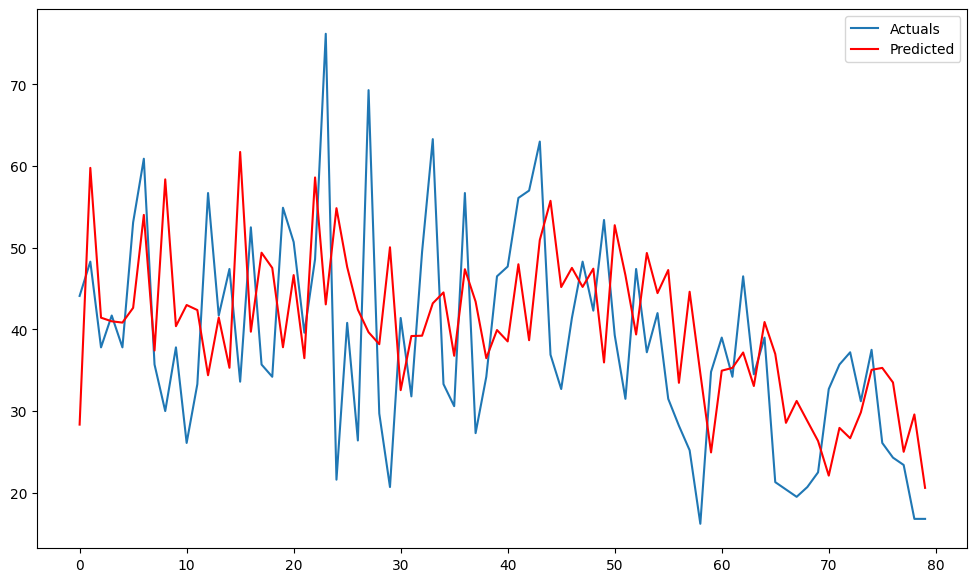

In [6]:
history = [x for x in train_log]
predictions = list()
predict_log=list()
for t in range(len(test_log)):
    model = sm.tsa.SARIMAX(history, order=my_order, seasonal_order=my_seasonal_order,enforce_stationarity=False,enforce_invertibility=False)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    predict_log.append(output[0])
    yhat = 10**output[0]
    predictions.append(yhat)
    obs = test_log[t]
    history.append(obs)
   # print('predicted=%f, expected=%f' % (output[0], obs))
#error = math.sqrt(mean_squared_error(test_log, predict_log))
#print('Test rmse: %.3f' % error)
# plot
figsize=(12, 7)
plt.figure(figsize=figsize)
pyplot.plot(test,label='Actuals')
pyplot.plot(predictions, color='red',label='Predicted')
pyplot.legend(loc='upper right')
pyplot.show()

In [7]:
df_preds = df[-80:]
df_preds['Predicted_Consumption'] = predictions

In [8]:
import plotly.graph_objects as go
import plotly.offline as py

In [9]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_preds['Date'], y=df_preds['Total_Consumption'],
                    mode='lines',
                    name='lines'))
fig.add_trace(go.Scatter(x=df_preds['Date'], y=df_preds['Predicted_Consumption'],
                    mode='lines',
                    name='lines'))

In [10]:
new_dates = pd.date_range(start='2021/07/31', end='2021/09/30')

In [11]:
train = df.Total_Consumption.values

my_order = (1, 1, 1)
my_seasonal_order = (1, 1, 1, 62)

model = sm.tsa.SARIMAX(train, order=my_order, seasonal_order=my_seasonal_order,enforce_stationarity=False,enforce_invertibility=False)
model_fit = model.fit()
output = model_fit.forecast(62)

In [12]:
listofzeros = [np.nan] * 62

In [13]:
data_new = {'Date':new_dates,
            'Total_Consumption':listofzeros,
            'Predicted_Consumption':output}

df_new_preds = pd.DataFrame(data_new)

In [14]:
df_all = pd.concat([df_preds, df_new_preds], ignore_index=True)

In [15]:
df_all.head(2)

,Date,Total_Consumption,Predicted_Consumption
0,2021-05-09,44.1,28.343763
1,2021-05-10,48.3,59.779544


In [16]:
df_all['MAE'] = df_all['Total_Consumption'] - df_all['Predicted_Consumption']

In [17]:
df_anoms = df_all[df_all['MAE'] >= 15]
df_anoms.reset_index(drop=True, inplace=True)

In [18]:
df_anoms.head(2)

,Date,Total_Consumption,Predicted_Consumption,MAE
0,2021-05-09,44.1,28.343763,15.756237
1,2021-05-22,56.7,34.386636,22.313364


In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_all['Date'], y=df_all['Total_Consumption'],
                    mode='lines',
                    name='Actual Consumption'))
fig.add_trace(go.Scatter(x=df_all['Date'], y=df_all['Predicted_Consumption'],
                    mode='lines',
                    name='Forecasted Consumption'))
fig.add_trace(go.Scatter(x=df_anoms['Date'], y=df_anoms['Total_Consumption'],
                    mode='markers',
                    name='Excess Consumption'))
fig.update_traces(marker=dict(size=5, 
                              line=dict(width=5,
                                        color='red')))

In [ ]:
# import plotly.graph_objects as go
# import plotly.io

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=[1, 2, 3], y=[4, 5, 6], mode='lines', name='Test Line'))

# print("🔄 Generating test PDF...")
# plotly.io.write_image(fig, "test_output.pdf", format="pdf", scale=0.5)
# print("✅ Test PDF generated successfully!")

import plotly.graph_objects as go
import plotly.io as pio

# Ensure Plotly uses Kaleido
pio.kaleido.scope.mathjax = None  

fig = go.Figure()
fig.add_trace(go.Scatter(x=[1, 2, 3], y=[4, 5, 6], mode='lines', name='Test Line'))

print("🔄 Generating test PDF...")
fig.write_image("test_output.pdf", format="pdf", scale=0.5)
print("✅ Test PDF generated successfully!")


🔄 Generating test PDF...


In [ ]:
import smtplib, ssl
from smtplib import SMTPException
from pathlib import Path
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email.mime.text import MIMEText
from email.utils import COMMASPACE, formatdate
from email import encoders
import plotly
import datetime
import time

for i in df_anoms['Date'][:1]:
    fig = go.Figure()
    df_anoms_temp = df_anoms[df_anoms['Date'] == i]
    df_anoms_temp.reset_index(drop=True, inplace=True)
    df_all_temp = df_all[df_all['Date'] <= i + datetime.timedelta(days=1)]
    df_all_temp.reset_index(drop=True, inplace=True)
    fig.add_trace(go.Scatter(x=df_all_temp['Date'], y=df_all_temp['Total_Consumption'],
                        mode='lines',
                        name='Actual Consumption'))
    fig.add_trace(go.Scatter(x=df_all_temp['Date'], y=df_all_temp['Predicted_Consumption'],
                        mode='lines',
                        name='Forecasted Consumption'))
    fig.add_trace(go.Scatter(x=df_anoms_temp['Date'], y=df_anoms_temp['Total_Consumption'],
                        mode='markers',
                        name='Excess Consumption'))
    fig.update_traces(marker=dict(size=5, 
                                  line=dict(width=5,
                                            color='red')))
    i = str(i)
    i = i[:-9]

    print(f"🔄 Generating PDF for date: {i}")
    plotly.io.write_image(fig, f'output_file_{i}.pdf', format='pdf', scale=0.5)
    print(f"✅ PDF Generated: output_file_{i}.pdf")
    # plotly.io.write_image(fig, 'output_file'+i+'.pdf', format='pdf')
    # plotly.io.write_image(fig, f'output_file_{i}.pdf', format='pdf', scale=0.5)
    SUBJECT = "Early Warning - Abnormal usage of Electricity Detected! - Dated:" + i

    msg = MIMEMultipart()
    msg['Subject'] = SUBJECT 
    msg['From'] = 'mahathikavikondala@gmail.com'
    msg['To'] = 'umangbasuthkar51@gmail.com'

    body = "Electra.AI has detected unusal usage of electricity. This is an early warning generated to keep the electricity bill under control."

    msg.attach(MIMEText(body, 'plain'))

    filename = 'output_file'+i+'.pdf'
    print(f"📂 Reading attachment: output_file_{i}.pdf")
    attachment = open(f'output_file_{i}.pdf', "rb")
    print("✅ Attachment loaded successfully.")
    # attachment = open('output_file'+i+'.pdf', "rb")

    part = MIMEBase('application', "octet-stream")
    part.set_payload((attachment).read())
    encoders.encode_base64(part)

    part.add_header('Content-Disposition', "attachment; filename= %s" % filename)

    msg.attach(part)
    context = ssl.create_default_context()
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.ehlo()
    server.starttls(context=context)
    server.ehlo()
    server.login(msg['From'], 'xnqf vatv yacm vsvq')
    print("📧 Sending email...")
    server.sendmail(msg['From'], msg['To'], msg.as_string())
    print(f"✅ Email sent successfully for Date: {i}")
    server.sendmail(msg['From'], msg['To'], msg.as_string())
    print('Email sent successfully for Date:', i)
    time.sleep(2)



# import smtplib
# from email.mime.multipart import MIMEMultipart
# from email.mime.text import MIMEText

# msg = MIMEMultipart()
# msg['From'] = 'mahathikavikondala@gmail.com'
# msg['To'] = 'mahathikavikondala@gmail.com'
# msg['Subject'] = 'Test Email'

# msg.attach(MIMEText('This is a test email without attachment.', 'plain'))

# server = smtplib.SMTP_SSL('smtp.gmail.com', 465)
# server.login("mahathikavikondala@gmail.com", "xnqf vatv yacm vsvq")
# server.sendmail(msg['From'], msg['To'], msg.as_string())
# server.quit()

# print("Test email sent successfully!")


🔄 Generating PDF for date: 2021-05-09


In [21]:
# plotly.io.write_image(fig, 'output_file.pdf', format='pdf')

In [22]:
# import smtplib, ssl
# from smtplib import SMTPException
# from pathlib import Path
# from email.mime.multipart import MIMEMultipart
# from email.mime.base import MIMEBase
# from email.mime.text import MIMEText
# from email.utils import COMMASPACE, formatdate
# from email import encoders

In [23]:
# sender = 'debadriworkshop@gmail.com'
# receivers = ['debadridtt@gmail.com']

# message = """From: debadriworkshop@gmail.com
# To: debadridtt@gmail.com
# Subject: Early Warning - Abnormal usage of Electricity Detected! - Dated: {date}

# Electra.AI has detected unusal usage of electricity. This is an early warning generated to keep the electricity bill under control.
# """

# context = ssl.create_default_context()

# try:
#     smtpObj = smtplib.SMTP('smtp.gmail.com', 587)
#     smtpObj.ehlo()
#     smtpObj.starttls(context=context)
#     smtpObj.ehlo()
#     smtpObj.login(sender, 'gta4vicecity')
#     smtpObj.sendmail(sender, receivers, message)     
#     print ("Successfully sent email")
# except SMTPException:
#     print ("Error: unable to send email")

In [24]:
# SUBJECT = "Early Warning - Abnormal usage of Electricity Detected! - Dated: {date}"

# msg = MIMEMultipart()
# msg['Subject'] = SUBJECT 
# msg['From'] = 'debadriworkshp@gmail.com'
# msg['To'] = 'debadridtt@gmail.com'

# body = "Electra.AI has detected unusal usage of electricity. This is an early warning generated to keep the electricity bill under control."

# msg.attach(MIMEText(body, 'plain'))

# filename = "output_file.pdf"
# attachment = open("output_file.pdf", "rb")

# part = MIMEBase('application', "octet-stream")
# part.set_payload((attachment).read())
# encoders.encode_base64(part)
    
# part.add_header('Content-Disposition', "attachment; filename= %s" % filename)

# msg.attach(part)

# server = smtplib.SMTP('smtp.gmail.com', 587)
# server.ehlo()
# server.starttls(context=context)
# server.ehlo()
# server.login(sender, 'gta4vicecity')
# server.sendmail(msg['From'], msg['To'], msg.as_string())

In [25]:
# df_all.to_csv(r'D:\Skills\Challenges\Mitsubishi PropTech\Datasets\electrical_forecast.csv', index=False)